In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from statsmodels.graphics.mosaicplot import mosaic


# Predictive Maintenance Draft

[description](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset)

[data](https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv)

synthetic dataset

Columns:

Product information:
 - UDI - Unique identifier. NOT USED.
 - Product ID - Product number. Consist of the type and unique serial number. NOT USED.
 - Type -  Product type. 3 in total: L, M, H, stand for Low, Medium and High quality variant of the product.
 
 Process parameters:
 - Air temperature [K] - ambient temperature of the air around the machine
 - Process temperature [K] - temperature of the process
 - Rotational speed [rpm] - motor speed
 - Torque [Nm] - motor torque
 - Tool wear [min] - machining tool wear. Tool is replaced whenever it breaks (TWF failure mode).
 
 Failures:
 - Machine failure - 1 (failure) or 0 (normal operation). Set to 1 whenever a failure mode from the 5 listed below occurs. The exact failure mode that triger the `machine failure` variable is not known by the operator and shall not be predicted. The 5 columns below are only created to together generate the overall `machine failure` column (this column).
 - TWF - tool wear failure. NOT USED.
 - HDF - heat dissipation failure. NOT USED.
 - PWF - power failure. NOT USED.
 - OSF - overstrain failure. NOT USED.
 - RNF - random failures. NOT USED.

## 1. Pre-process

### Read the data

In [3]:
machine = pd.read_csv("data/input/ai4i2020.csv")

In [4]:
machine.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
machine.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [6]:
machine.shape

(10000, 14)

In [7]:
machine.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


### Tidy columns

Filter.

In [8]:
columns_to_remain = [
    'Type',
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'Machine failure',
]
machine = machine[columns_to_remain]

Rename.

In [9]:
new_column_names = [
    'product_type',
    'air_temp',
    'process_temp',
    'speed',
    'torque',
    'tool_wear',
    'failure',
]
machine.columns = new_column_names

### Convert temperatures from K to C

In [24]:
machine[["air_temp", "process_temp"]] = machine[["air_temp", "process_temp"]] - 273.15

### Check for missing values

In [10]:
machine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_type  10000 non-null  object 
 1   air_temp      10000 non-null  float64
 2   process_temp  10000 non-null  float64
 3   speed         10000 non-null  int64  
 4   torque        10000 non-null  float64
 5   tool_wear     10000 non-null  int64  
 6   failure       10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


### Create new variable: `elapsed_time`
Total duration of machining calculated by adding up all `tool_wear` durations.

In minutes.

In [97]:
elapsed_time_data = machine.tool_wear.cumsum()

machine["elapsed_time"] = pd.to_timedelta(elapsed_time_data, unit = "minutes")

Sanity check that total machine time is indeed ~ 750 days = 2 years.

In [148]:
# machine[["elapsed_time", "tool_wear"]][:30]

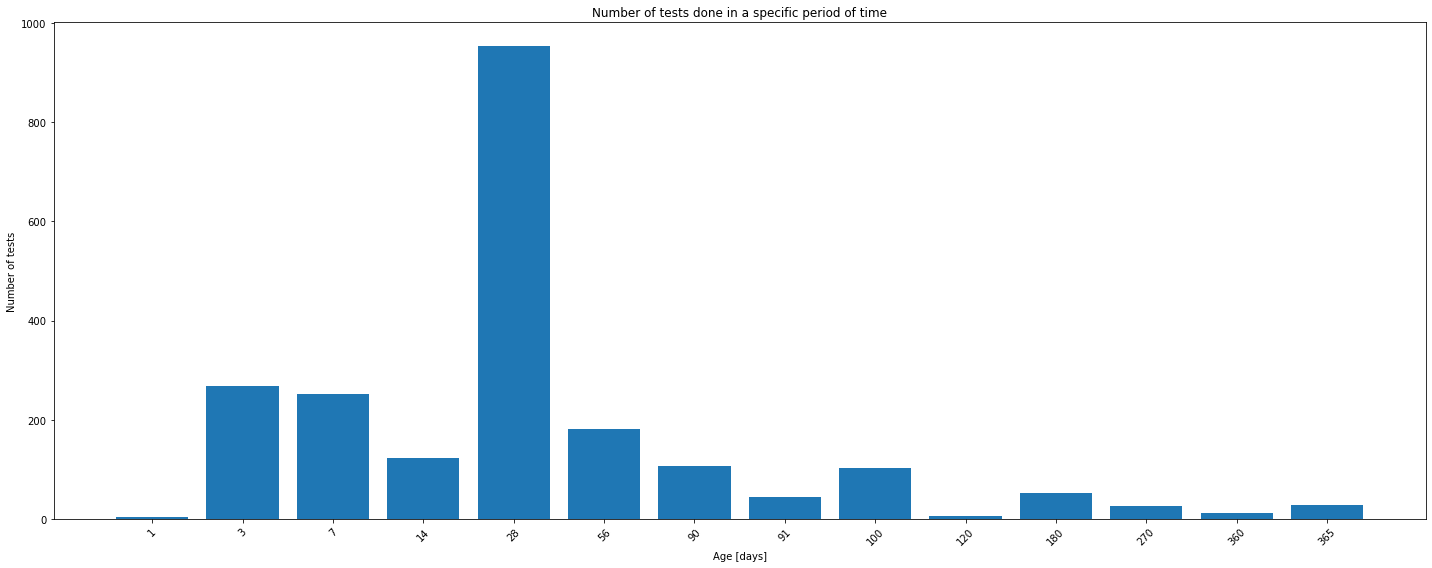

In [162]:
days = [str(x) for x in [1, 3, 7, 14, 28, 56, 90, 91, 100, 120, 180, 270, 360, 365]]
tests_by_days = [4, 268, 252, 124, 953, 182, 108, 44, 104, 6, 52, 26, 12, 28]
def plot_bar_of_tests(important_days, tests_by_days):
    plt.figure(figsize = (20,8))
    plt.bar(important_days, tests_by_days)
    plt.xticks(important_days, rotation = 45)
    plt.xlabel("Age [days]")
    plt.ylabel("Number of tests")
    plt.title("Number of tests done in a specific period of time")
    plt.tight_layout()
    plt.show()
plot_bar_of_tests(days, tests_by_days)

In [155]:
machine.tool_wear[60:80]

60    167
61    169
62    172
63    174
64    177
65    179
66    181
67    184
68    189
69    191
70    193
71    196
72    198
73    200
74    202
75    204
76    206
77    208
78      0
79      2
Name: tool_wear, dtype: int64

In [156]:
machine.tool_wear.diff()[60:80]

60      2.0
61      2.0
62      3.0
63      2.0
64      3.0
65      2.0
66      2.0
67      3.0
68      5.0
69      2.0
70      2.0
71      3.0
72      2.0
73      2.0
74      2.0
75      2.0
76      2.0
77      2.0
78   -208.0
79      2.0
Name: tool_wear, dtype: float64

In [98]:
machine.elapsed_time.iloc[-1]

Timedelta('749 days 15:50:00')

In [99]:
machine.tool_wear.sum() / 60 / 24

749.6597222222222

### Create new variable: `power`
Calculated motor power. Shaft angular speed expressed in radians per second, T expressed in newton-meters.

In [12]:
# Convert speed from rpm to rad
speed_rad = machine.speed * 0.104719755

machine["power"] = speed_rad * machine.torque

## 2. Explore

### Explore proportions

Clues:
- product type `L` (low quality) has the highest proportion of failures
- almost 2/3 of all parts are `L`, only 10% are `H` 

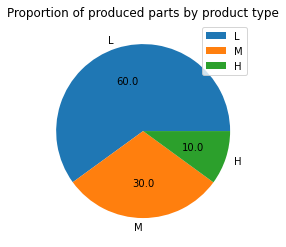

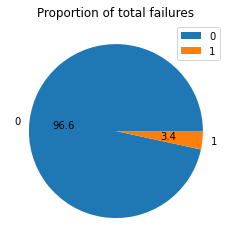

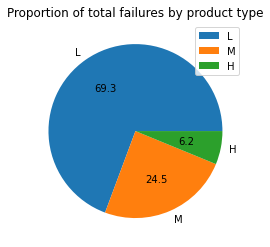

In [13]:
def plot_categories(data, title):
    plt.pie(data, labels=data.index, autopct= "%.1f")
    plt.title(title)
    plt.legend()
    plt.show()

num_parts_by_product_type = machine.product_type.value_counts()
plot_categories(num_parts_by_product_type, "Proportion of produced parts by product type")

num_parts_by_failure = machine.failure.value_counts()
plot_categories(num_parts_by_failure, "Proportion of total failures")

num_failures_by_product_type = machine[machine.failure == 1].product_type.value_counts()
plot_categories(num_failures_by_product_type, "Proportion of total failures by product type")

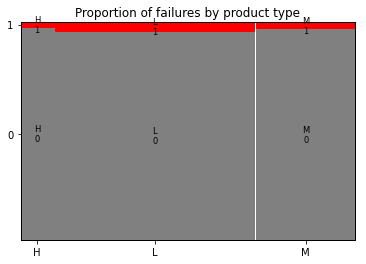

In [14]:
data = machine.groupby(["product_type", "failure"]).size()

props = lambda pair: {'color': 'r' if pair[1] == '1' else 'gray'}
mosaic(data=data, properties=props, title="Proportion of failures by product type")
plt.show()

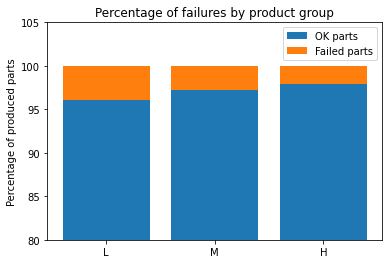

In [15]:
failure_pct = 100 * num_failures_by_product_type / num_parts_by_product_type
ok_pct = 100 - failure_pct

labels = num_failures_by_product_type.index

fig, ax = plt.subplots()

ax.bar(labels, ok_pct, label='OK parts')
ax.bar(labels, failure_pct, bottom=ok_pct, label='Failed parts')

ax.set_ylabel('Percentage of produced parts')
ax.set_title('Percentage of failures by product group')
ax.set_ylim(bottom=80)

ax.legend()
plt.show()

### Explore tool replacements and failures

Clues:
- Tool is replaced at roughly regular intervals, approx. 3.5 hours.
- No apparent relationship between failure occurrence and tool replacement.

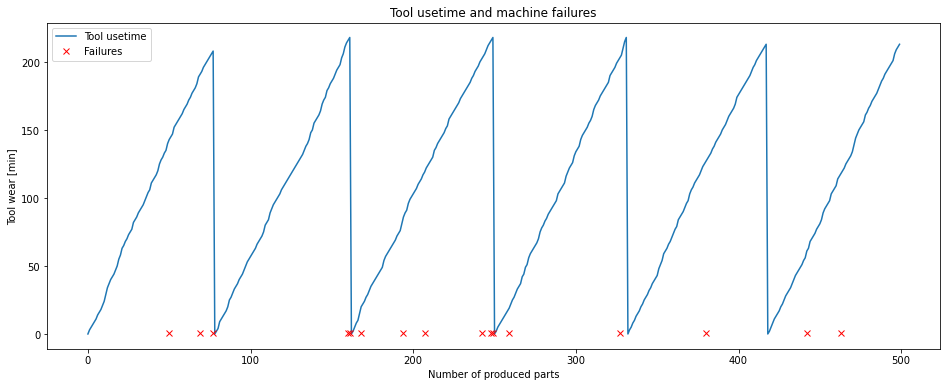

In [80]:
all_failures = machine[machine.failure == 1].failure

plt.figure(figsize=(16, 6))
plt.plot(machine.tool_wear[:500], label="Tool usetime")
plt.plot(all_failures[all_failures.index < 500], 'rx', label="Failures")
plt.xlabel("Number of produced parts")
plt.ylabel("Tool wear [min]")
plt.title("Tool usetime and machine failures")
plt.legend()
plt.show()

### Explore time series of single variables

Clues:
- todo

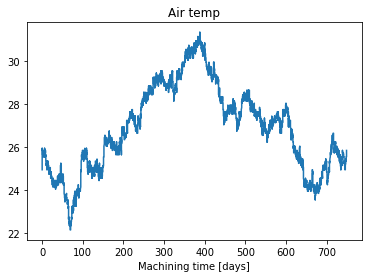

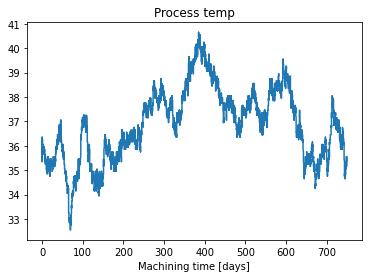

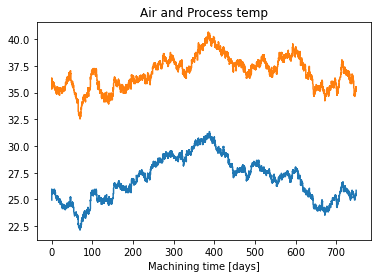

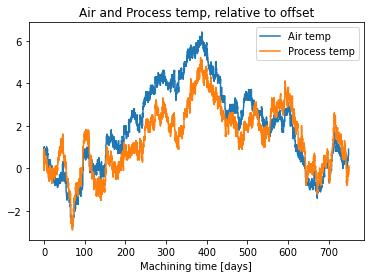

In [100]:
x = machine.elapsed_time.astype("timedelta64[D]")

plt.plot(x, machine.air_temp)
plt.xlabel("Machining time [days]")
plt.title("Air temp")
plt.show()

plt.plot(x, machine.process_temp)
plt.title("Process temp")
plt.xlabel("Machining time [days]")
plt.show()

plt.plot(x, machine.air_temp, label = "Air temp")
plt.plot(x, machine.process_temp, label = "Process temp")
plt.title("Air and Process temp")
plt.xlabel("Machining time [days]")
plt.show()

plt.plot(x, machine.air_temp - machine.air_temp[0], label = "Air temp")
plt.plot(x, machine.process_temp - machine.process_temp[0], label = "Process temp")
plt.title("Air and Process temp, relative to offset")
plt.xlabel("Machining time [days]")
plt.legend()
plt.show()

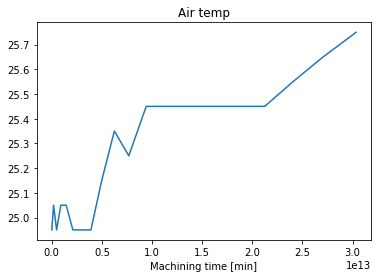

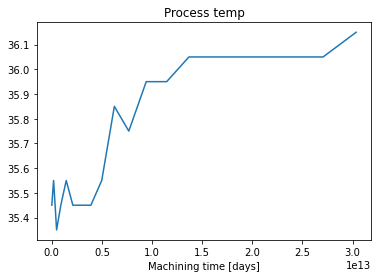

In [105]:
start, end = 0, 20
x = machine.elapsed_time[start: end]

plt.plot(x, machine.air_temp[start: end])
plt.xlabel("Machining time [min]")
plt.title("Air temp")
plt.show()

plt.plot(x, machine.process_temp[start: end])
plt.title("Process temp")
plt.xlabel("Machining time [days]")
plt.show()

In [107]:
x

0    0 days 00:00:00
1    0 days 00:03:00
2    0 days 00:08:00
3    0 days 00:15:00
4    0 days 00:24:00
5    0 days 00:35:00
6    0 days 00:49:00
7    0 days 01:05:00
8    0 days 01:23:00
9    0 days 01:44:00
10   0 days 02:08:00
11   0 days 02:37:00
12   0 days 03:11:00
13   0 days 03:48:00
14   0 days 04:28:00
15   0 days 05:10:00
16   0 days 05:54:00
17   0 days 06:41:00
18   0 days 07:31:00
19   0 days 08:26:00
Name: elapsed_time, dtype: timedelta64[ns]

In [132]:
indeces_with_final_tool_life = machine[machine.tool_wear == 0].index[1:] - 1
machine.iloc[indeces_with_final_tool_life].tool_wear.sum()

25663

In [136]:
s = pd.Series([0, 2, 5, 7, 10, 15, 0, 3, 8, 9])


In [137]:
s.cumsum()

0     0
1     2
2     7
3    14
4    24
5    39
6    39
7    42
8    50
9    59
dtype: int64

In [116]:
machine[machine.tool_wear == 0][1:].tool_wear

78      0
162     0
250     0
332     0
418     0
       ..
9672    0
9759    0
9834    0
9908    0
9989    0
Name: tool_wear, Length: 119, dtype: int64

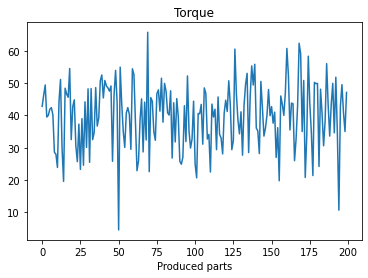

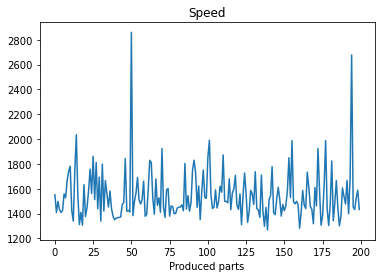

In [42]:
plt.plot(machine.torque[:200])
plt.title("Torque")
plt.xlabel("Produced parts")
plt.show()

plt.plot(machine.speed[:200])
plt.title("Speed")
plt.xlabel("Produced parts")
plt.show()

### Distributions of single variables

Clues:
 - `Air` and `process` temperatures does not seem to have normal distribution.
 - `Torque` and `Speed `seem normally distributed.
 - `Speed` distibution is asymmetric: has positive skew of ~2.

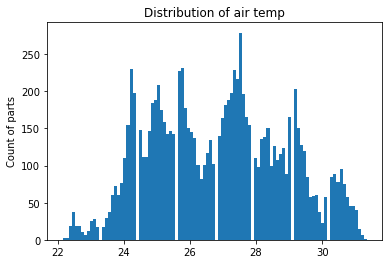

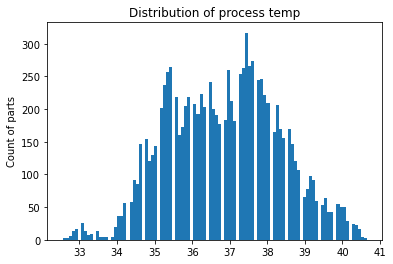

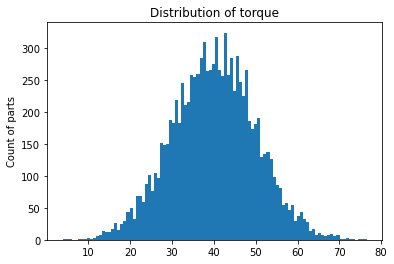

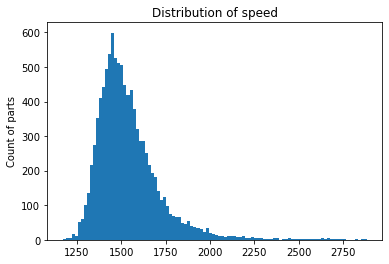

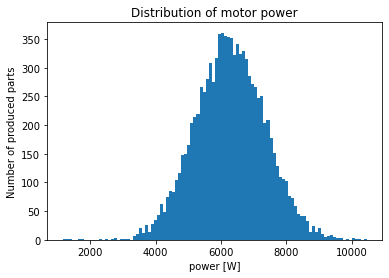

In [50]:
plt.hist(machine.air_temp, bins=100)
plt.ylabel("Count of parts")
plt.title("Distribution of air temp")
plt.show()

plt.hist(machine.process_temp, bins=100)
plt.ylabel("Count of parts")
plt.title("Distribution of process temp")
plt.show()

plt.hist(machine.torque, bins=100)
plt.ylabel("Count of parts")
plt.title("Distribution of torque")
plt.show()

plt.hist(machine.speed, bins=100)
plt.ylabel("Count of parts")
plt.title("Distribution of speed")
plt.show()

plt.hist(machine.power, bins=100)
plt.xlabel("power [W]")
plt.ylabel("Number of produced parts")
plt.title("Distribution of motor power")
plt.show()

In [48]:
machine.speed.skew(), machine.torque.skew()

(1.9931710047137523, -0.00951659584005855)

### Correlations

Clues:
 - Strong correlations: speed-power, speed-torque, process_temp-air_temp.
 - All the above make physical sense.
 - No other corr.

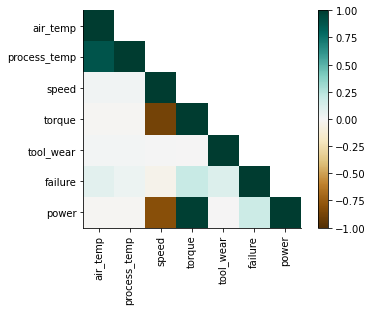

In [51]:
pear_corr = machine.corr()
pear_corr = pear_corr.where(np.tril(np.ones(pear_corr.shape)).astype("bool"))

plt.imshow(pear_corr, cmap='BrBG', vmin=-1, vmax=1)
plt.colorbar()
plt.yticks(range(pear_corr.shape[1]), pear_corr.columns)
plt.xticks(range(pear_corr.shape[1]), pear_corr.columns, rotation='vertical')
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

### Groups comparisons

Clues:
 - No significant difference in the distributions.

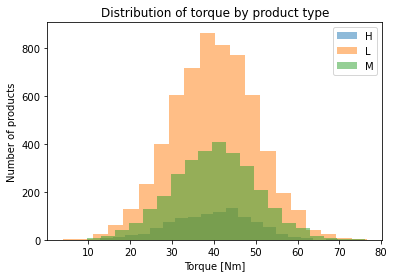

In [52]:
torque_by_product_type = machine.groupby("product_type").torque

for product_type, group_data in torque_by_product_type:
    plt.hist(group_data, label=product_type, alpha=0.5, bins=20)

plt.xlabel("Torque [Nm]")
plt.ylabel("Number of products")
plt.title("Distribution of torque by product type")
plt.legend()
plt.show()

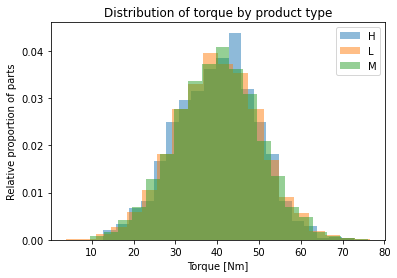

In [53]:
for product_type, group_data in torque_by_product_type:
    plt.hist(group_data, label=product_type, alpha=0.5, bins=20, density=True)

plt.xlabel("Torque [Nm]")
plt.ylabel("Relative proportion of parts")
plt.title("Distribution of torque by product type")
plt.legend()
plt.show()

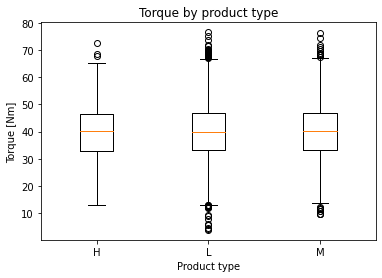

In [54]:
torque_by_product_type_dict = {k: v for k, v in torque_by_product_type}

plt.boxplot(torque_by_product_type_dict.values(),
            labels=torque_by_product_type_dict.keys())

plt.xlabel("Product type")
plt.ylabel("Torque [Nm]")
plt.title("Torque by product type")
plt.show()